In [4]:
# -- Bib
import os
import sys
sys.path.append("..")

import glob
from pathlib import Path
import networkx as nx
import geopandas as gpd
import pandas as pd
import datetime as dt
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
from dateutil.relativedelta import relativedelta
import mapclassify
from collections import defaultdict
from scipy.stats import linregress

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

idx = pd.IndexSlice

# -- base paths
basepath = Path.home().joinpath("Documents", "data")
cnespath = basepath.joinpath("opendatasus", "cnes")
geopath = basepath.joinpath("shapefilesceqgis")
simpath = basepath.joinpath("sim", "DBF")
gmlpath = basepath.joinpath("redes_aih")
ccapath = basepath.joinpath("cca_erneson")
figpath = gmlpath.joinpath("doc_final")

# -- load geo
geodata_df = gpd.read_parquet(geopath.joinpath("ce_geodata.parquet"))
ce_geodata_df = gpd.read_parquet(geopath.joinpath("ce_regiao_saude_municipios.parquet"))

pop_2022_ibge = pd.read_parquet(geopath.joinpath("pop_ce_2022_ibge.parquet"))
geodata_df = geodata_df.merge(pop_2022_ibge)


## **Macro original**

In [5]:
macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_COLOR", "MACRO_NOME", "geometry_macro"]]

original_df = geodata_df.groupby("MACRO_ID")['pop_2022'].sum().reset_index()
macro_names_original = {1: 'Fortaleza', 2: 'Sertão Central', 3: 'Litoral Leste', 4: 'Norte', 5: 'Cariri'}
original_df["Macrorregião de Saúde"] = original_df["MACRO_ID"].map(macro_names_original)
original_df1 = original_df[["Macrorregião de Saúde", "pop_2022", "MACRO_ID"]].rename({'pop_2022': "População"}, axis=1)
original_df1 = original_df1.merge(macro_df[["MACRO_ID", "MACRO_COLOR"]])
original_df1["Pop. %"] = (original_df1["População"]/original_df1["População"].sum())*100
original_df1

,Macrorregião de Saúde,População,MACRO_ID,MACRO_COLOR,Pop. %
0,Fortaleza,4553473,1,#ef476f,51.773681
1,Sertão Central,618818,2,#ffb300,7.036055
2,Litoral Leste,530927,3,#04ae81,6.036721
3,Norte,1644010,4,#118ab2,18.692644
4,Cariri,1447729,5,#073b4c,16.460899


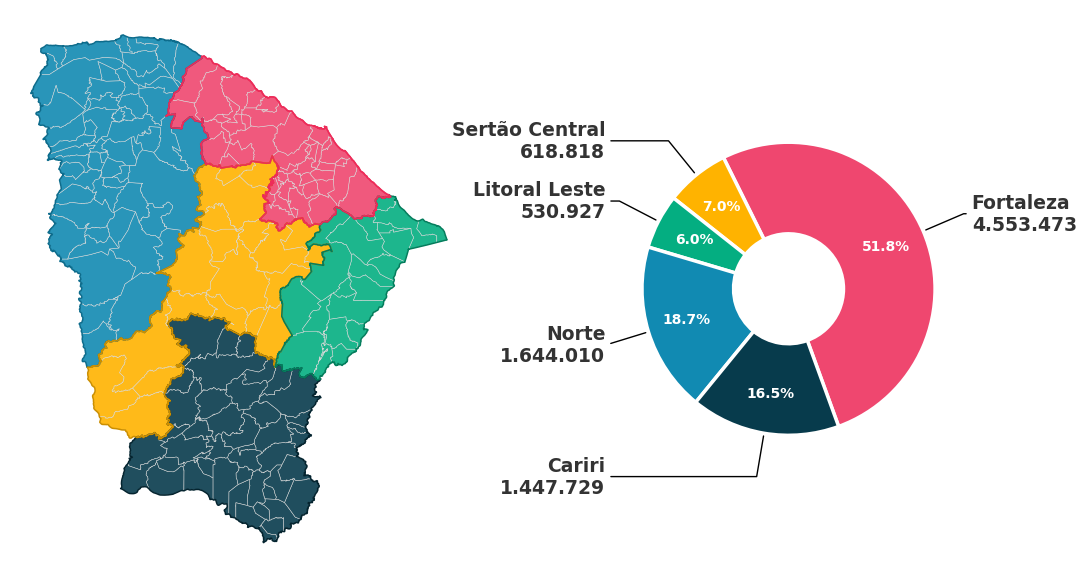

In [6]:
border_macro = {"#ef476f":"#ed2c59", "#073b4c":"#04242f", "#118ab2": "#0d6c8c", "#ffb300": "#cc8f00", "#04ae81": "#037d5c"}

# -- new geometry ceará
fig_new, (AX1, AX2) = plt.subplots(1,2, figsize=(13,8))

#geodata_df.set_geometry('geometry_municip').plot(ax=AX, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.6)
geodata_df.set_geometry('geometry_municip').plot(ax=AX1, color=geodata_df["MACRO_COLOR"], edgecolor="#d9d9d9", linewidth=0.4, alpha=0.9)

macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_COLOR", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=AX1, color="none", edgecolor=macro_df["MACRO_COLOR"].map(border_macro), linewidth=1.1)
macro_df[macro_df["MACRO_ID"]==1].plot(ax=AX1, color="none", edgecolor="#ed2c59", linewidth=1.1)
AX1.axis('off')


## -- PIE CHART
radius = 0.8
values = original_df1["Pop. %"].tolist()
label_macro_name = original_df1["Macrorregião de Saúde"].tolist()
label_pop_abs = original_df1["População"].tolist()
wedges, texts, _ = AX2.pie(values, colors=original_df1["MACRO_COLOR"], startangle=-70, radius=radius, autopct='%1.1f%%', pctdistance=0.725,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='white', weight='bold', fontsize=10))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}\n{label_pop_abs[i]:,}".replace(",","."), xy=(x, y), fontsize=13.5, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]}", xy=(x, 1.2*y), fontsize=12, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
    #            horizontalalignment=horizontalalignment)
#fig_new.savefig(basepath.joinpath("redes_aih", "doc_final", "pop_macro_original_pie.png"), dpi=250, bbox_inches='tight')

In [ ]:
proposal_color = {1: "#ef476f", 3: "#073b4c", 6:"#04ae81", 8:"#118ab2", 5: "#ffb300",
                  2: "#f48ada", 4: "#ef7347", 7:"#14b1eb"}

border_proposal_macro = {"#ef476f":"#ed2c59", "#073b4c":"#04242f", "#118ab2": "#0d6c8c", 
                         "#ffb300": "#cc8f00", "#04ae81": "#037d5c", "#14b1eb":"#108ebc",
                         "#f48ada": "#f05ccb", "#ef7347": "#ed5f2c"}

proposal_df = ce_geodata_df.groupby("REGIAO_SAUDE_8")['pop_2022'].sum().reset_index()
name_macro = {
    1: "Grande Fortaleza\nBaturité", 2: "Litoral Oeste\nVale do Curu\nLitoral Norte",
    3: "Cariri", 4: "Centro Sul", 5: "Sertão Central", 6: "Litoral Leste\nJaguaribe",
    7: "Sertão dos Inhamuns\nCrateús", 8: "Serra da Ibiapaba\nSertão de Sobral"
}
#name_macro = {
#    1: "Grande Fortaleza\nBaturité", 2: "Litoral Oeste\nLitoral Norte",
#    3: "Cariri", 4: "Centro Sul", 5: "Sertão Central", 6: "Litoral Leste\nJaguaribe",
#    7: "Sertão dos Inhamuns\nCrateús", 8: "Serra da Ibiapaba\nSertão de Sobral"
#}
proposal_df["Macrorregião de Saúde"] = proposal_df["REGIAO_SAUDE_8"].map(name_macro)
proposal_df1 = proposal_df[["Macrorregião de Saúde", "pop_2022", "REGIAO_SAUDE_8"]].rename({'pop_2022': "População"}, axis=1).sample(frac=1.0, random_state=2)
proposal_df1["Pop. %"] = (proposal_df1["População"]/proposal_df1["População"].sum())*100
proposal_df1["MACRO_COLOR"] = proposal_df1["REGIAO_SAUDE_8"].map(proposal_color)
proposal_df1